References
1. https://wikidocs.net/20238
1. https://kutar37.tistory.com/39


In [7]:
from matplotlib import pyplot as plt

In [8]:
critics = {
    'Lisa Rose': {
        'Lady in the Water': 2.5,
        'Snakes on a Plane': 3.5,
        'Just My Luck': 3.0,
        'Superman Returns': 3.5,
        'You, Me and Dupree': 2.5,
        'The Night Listener': 3.0
    },

    'Gene Seymour': {
        'Lady in the Water': 3.0,
        'Snakes on a Plane': 3.5,
        'Just My Luck': 1.5,
        'Superman Returns': 5.0,
        'The Night Listener': 3.0,
        'You, Me and Dupree': 3.5
    },

    'Michael Phillips': {
        'Lady in the Water': 2.5,
        'Snakes on a Plane': 3.5,
        'Superman Returns': 3.5,
        'The Night Listener': 4.0
    },

    'Claudia Puig': {
        'Snakes on a Plane': 3.5,
        'Just My Luck': 3.0,
        'The Night Listener': 4.5,
        'Superman Returns': 4.0,
        'You, Me and Dupree': 2.5
    },

    'Mick LaSalle': {
        'Lady in the Water': 3.0,
        'Snakes on a Plane': 4.0,
        'Just My Luck': 2.0,
        'Superman Returns': 3.0,
        'The Night Listener': 3.0,
        'You, Me and Dupree': 2.0
    },

    'Jack Mattheuws': {
        'Lady in the Water': 3.0,
        'Snakes on a Plane': 4.0,
        'The Night Listener': 3.0,
        'Superman Returns': 5.0,
        'You, Me and Dupree': 3.5
    },

    'Toby': {
        'Snakes on a Plane': 4.5,
        'You, Me and Dupree': 1.0,
        'Superman Returns': 4.0
    }
}

In [9]:
import pandas as pd

critics_df = pd.DataFrame(critics)
critics_df.head()

,Lisa Rose,Gene Seymour,Michael Phillips,Claudia Puig,Mick LaSalle,Jack Mattheuws,Toby
Lady in the Water,2.5,3.0,2.5,NaN,3.0,3.0,NaN
Snakes on a Plane,3.5,3.5,3.5,3.5,4.0,4.0,4.5
Just My Luck,3.0,1.5,NaN,3.0,2.0,NaN,NaN
Superman Returns,3.5,5.0,3.5,4.0,3.0,5.0,4.0
"You, Me and Dupree",2.5,3.5,NaN,2.5,2.0,3.5,1.0


In [10]:
# Euclidean Distance
def sim_distance(prefs, person1, person2):
    # 공통 항목 추출
    si = dict()

    for item in prefs[person1]:
        if item in prefs[person2]:
            si[item] = 1

    # 공통 평가 항목이 없는 경우 0 리턴
    if len(si) == 0: return 0

    # person1의 item이 person2에서도 존재한다면, person1과 person2의 item 평점 차이의 제곱한 값을 더한 후 제곱 근을 계산
    sum_of_squares = sum([(prefs[person1][item] - prefs[person2][item])**2 for item in prefs[person1] if item in prefs[person2]])

    return 1/(1+sqrt(sum_of_squares))

# Pearson correlation coefficient
def sim_pearson(prefs, p1, p2):
    # 같이 평가한 항목들의 목록을 구함
    si = dict()

    for item in prefs[p1]:
        if item in prefs[p2]: si[item] = 1

    # 공통 항목 개수
    n = len(si)

    # 공통 항목이 없으면 0 리턴
    if n==0: return 0

    # 모든 선호도를 합산
    sum1 = sum([prefs[p1][it] for it in si])
    sum2 = sum([prefs[p2][it] for it in si])

    # 제곱의 합을 계산
    sum1Sq = sum([(prefs[p1][it])**2 for it in si])
    sum2Sq = sum([(prefs[p2][it])**2 for it in si])

    # 곱의 합을 계산
    pSum = sum([prefs[p1][it] * prefs[p2][it] for it in si])

    # 피어슨 점수 계산
    num = pSum - (sum1*sum2/n)
    den = sqrt((sum1Sq-pow(sum1,2)/n) * (sum2Sq-pow(sum2,2)/n))
    if den==0: return 0

    r = num/den

    return r

# 선호도 dict에 최적의 상대편을 구함
# 결과 개수와 유사도 함수는 옵션
def top_matches(prefs, person, n=5, similarity=sim_pearson):
    scores = [(similarity(prefs, person, other), other) for other in prefs if other!=person]

    scores.sort()
    scores.reverse()
    return scores[:n]

# 다른 사람과의 순위의 가중 평균값을 이용해서 특정 사람을 추천
def get_recommendations(prefs, person, similarity=sim_pearson):
    totals = dict()
    simSums = dict()

    for other in prefs:
        # 나를 제외 하고
        if other == person: continue
        sim = similarity(prefs, person, other)  # person과 other 사이의 상관계수 점수를 구함

        # 0 이하 점수는 무시
        if sim<=0: continue

        for item in prefs[other]:   # ohter가 본 영화들의 list
            # 내가 보지 못한 영화만 대상
            if item not in prefs[person] or prefs[person][item] == 0:
                # 유사도 * 점수
                totals.setdefault(item, 0)
                totals[item] += prefs[other][item]*sim  # other가 평가한 영화의 점수 * person과 other의 상관계수

                # 유사도 합계
                simSums.setdefault(item, 0)
                simSums[item] += sim

    # 정규화된 목록 생성
    rankings = [ (total/simSums[item], item) for item, total in totals.items() ]

    # 정렬된 목록 리턴
    rankings.sort()
    rankings.reverse()
    return rankings

# 사람을 제품 기준으로 dict 변경
def transform_prefs(prefs):
    result = dict()

    for person in prefs:
        for item in prefs[person]:
            result.setdefault(item, dict())

            result[item][person] = prefs[person][item]

    return result

In [11]:
# critics data 이용해 scatter plot 그리기
def drawGraph(data, name1, name2):
    plt.figure(figsize=(14,8)) # plot 크기설정
    
    # plot 좌표를 위한 list 선언
    li = []
    li2 = []
    
    for i in critics[name1]: # i = 키 값
        if i in data[name2]: # 같은 영화를 평가했을때만
            li.append(critics[name1][i]) # name1의 평점 li[]에 추가
            li2.append(critics[name2][i]) # name2의 평점 li2[]에 추가
            plt.text(critics[name1][i],critics[name2][i],i) # 영화 제목 text 찍기
            
    plt.plot(li,li2,'ro') #plot그리기
    
    #각 축의 크기 설정 (0에서 6까지)
    plt.axis([0,6,0,6])
 
    # x축과 y축 이름 설정
    plt.xlabel(name1)
    plt.ylabel(name2)
 
    # 그리기
    plt.show()

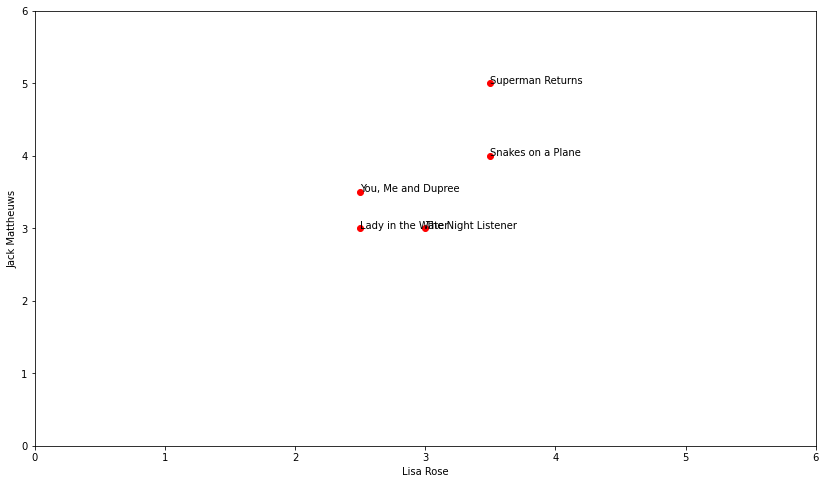

In [12]:
drawGraph(critics,'Lisa Rose','Jack Mattheuws')

In [13]:
from math import sqrt
# 피어슨 상관계수 구하기
def sim_pearson(data, name1, name2):
    sumX=0 # X의 합
    sumY=0 # Y의 합
    sumPowX=0 # X 제곱의 합
    sumPowY=0 # Y 제곱의 합
    sumXY=0 # X*Y의 합
    count=0 #영화 개수
    
    for i in data[name1]: # i = key
        if i in data[name2]: # 같은 영화를 평가했을때만
            sumX+=data[name1][i]
            sumY+=data[name2][i]
            sumPowX+=pow(data[name1][i],2)
            sumPowY+=pow(data[name2][i],2)
            sumXY+=data[name1][i]*data[name2][i]
            count+=1
    
    return ( sumXY- ((sumX*sumY)/count) )/ sqrt( (sumPowX - (pow(sumX,2) / count)) * (sumPowY - (pow(sumY,2)/count)))

In [14]:
sim_pearson(critics,'Lisa Rose','Jack Mattheuws')

0.7470178808339965

In [15]:
sim_pearson(critics,'Lisa Rose','Michael Phillips')

0.6225430174794672

In [16]:
# 딕셔너리 돌면서 상관계수순으로 정렬
def top_match(data, name, index=3, sim_function=sim_pearson):
    li=[]
    for i in data: #딕셔너리를 돌고
        if name!=i: #자기 자신이 아닐때만
            li.append((sim_function(data,name,i),i)) #sim_function()을 통해 상관계수를 구하고 li[]에 추가
    li.sort() #오름차순
    li.reverse() #내림차순
    return li[:index]

In [17]:
top_match(critics, 'Lisa Rose',6)

[(0.9912407071619299, 'Toby'),
 (0.7470178808339965, 'Jack Mattheuws'),
 (0.6225430174794672, 'Michael Phillips'),
 (0.5940885257860044, 'Mick LaSalle'),
 (0.5669467095138396, 'Claudia Puig'),
 (0.39605901719066977, 'Gene Seymour')]

In [18]:
def getRecommendation (data,person,sim_function=sim_pearson):
    result = top_match(critics, person ,len(data))
    
    simSum=0 # 유사도 합을 위한 변수
    score=0 # 평점 합을 위한 변수
    li=[] # 리턴을 위한 리스트
    score_dic={} # 유사도 총합을 위한 dic
    sim_dic={} # 평점 총합을 위한 dic
 
    for sim,name in result: # 튜플이므로 한번에 
        if sim<0 : continue #유사도가 양수인 사람만
        for movie in data[name]: 
            if movie not in data[person]: #name이 평가를 내리지 않은 영화
                score+=sim*data[name][movie] # 그사람의 영화평점 * 유사도
                score_dic.setdefault(movie,0) # 기본값 설정
                score_dic[movie]+=score # 합계 구함
 
                # 조건에 맞는 사람의 유사도의 누적합을 구한다
                sim_dic.setdefault(movie,0) 
                sim_dic[movie]+=sim
 
            score=0  #영화가 바뀌었으니 초기화한다
    
    for key in score_dic: 
        score_dic[key]=score_dic[key]/sim_dic[key] # 평점 총합/ 유사도 총합
        li.append((score_dic[key],key)) # list((tuple))의 리턴을 위해서.
    li.sort() #오름차순
    li.reverse() #내림차순
    return li

In [19]:
getRecommendation(critics, 'Jack Mattheuws')

[(2.1505590044630245, 'Just My Luck')]